# Практическое задание к уроку 1

1. Добиться вразумительного результата от модели, собранной на занятии (3 угаданные картинки из 4 предложенных на семинаре). Варианты изменений:
 * изменение слоёв и их количества;
 * изменение метода оптимизации; 
 * изменение процесса обучения; 
 * для продвинутых: преобразование данных.


In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
import torchvision.transforms as transforms

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
PATH = 'data'

download = not os.path.isdir(PATH)
train_dataset = torchvision.datasets.CIFAR10(root=PATH,
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=download)

In [4]:
image, label = train_dataset[0]
print(image.size())
print(label)

torch.Size([3, 32, 32])
6


(-0.5, 31.5, 31.5, -0.5)

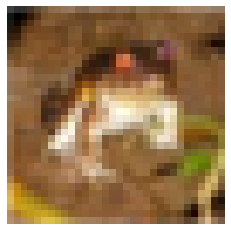

In [5]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis('off')

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [7]:
test_dataset = torchvision.datasets.CIFAR10(root=PATH, 
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#### Определяем модель
Постоим маленький аналог VGG архитектуры

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.conv6 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pad = (1, 1, 1, 1)  # Для F.pad, чтобы сверка оставляла нулевые края

    def forward(self, x):
        x = F.relu(F.pad(self.conv1(x), self.pad))
        x = self.pool(F.relu(F.pad(self.conv2(x), self.pad)))

        x = F.relu(F.pad(self.conv3(x), self.pad))
        x = self.pool(F.relu(F.pad(self.conv4(x), self.pad)))
        
        x = F.relu(F.pad(self.conv5(x), self.pad))
        x = self.pool(F.relu(F.pad(self.conv6(x), self.pad)))
        
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())  # SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Процесс обучения

In [11]:
%%time
for epoch in range(20):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        inputs, labels = inputs.to(device), labels.to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
    print('[epoch %d] loss: %.3f' % (epoch + 1, running_loss / 2000))
    running_loss = 0.0

print('Training is finished!')

[epoch 1] loss: 0.689
[epoch 2] loss: 0.490
[epoch 3] loss: 0.409
[epoch 4] loss: 0.359
[epoch 5] loss: 0.320
[epoch 6] loss: 0.290
[epoch 7] loss: 0.264
[epoch 8] loss: 0.243
[epoch 9] loss: 0.221
[epoch 10] loss: 0.207
[epoch 11] loss: 0.186
[epoch 12] loss: 0.171
[epoch 13] loss: 0.156
[epoch 14] loss: 0.144
[epoch 15] loss: 0.132
[epoch 16] loss: 0.120
[epoch 17] loss: 0.108
[epoch 18] loss: 0.100
[epoch 19] loss: 0.092
[epoch 20] loss: 0.083
Training is finished!
CPU times: user 2min 38s, sys: 3.08 s, total: 2min 41s
Wall time: 2min 42s


#### Проверка модели на 4-х изображениях

In [12]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

GroundTruth:    cat  ship  ship plane


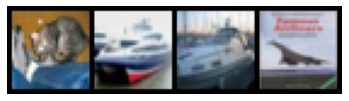

In [13]:
net = net.to('cpu')
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.imshow(imgs.permute(1, 2, 0).numpy())
plt.axis('off')
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


2. Взять часть, где мы делали один шаг обучения, и обернуть его в цикл по схеме, как обучали модель в конце занятия.

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 2)

    def forward(self, x):
        x = self.linear(x)
        return x


net = Net()

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

In [17]:
inputs = Variable(torch.randn(2), requires_grad = True)
labels = Variable(torch.randn(2), requires_grad = False)

In [18]:
EPOCHS = 10

for epoch in range(EPOCHS):
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    print('[epoch %d] loss: %.5f' % (epoch + 1, loss))

[epoch 1] loss: 6.59797
[epoch 2] loss: 6.57478
[epoch 3] loss: 6.55168
[epoch 4] loss: 6.52866
[epoch 5] loss: 6.50572
[epoch 6] loss: 6.48286
[epoch 7] loss: 6.46008
[epoch 8] loss: 6.43738
[epoch 9] loss: 6.41476
[epoch 10] loss: 6.39222


3. Переписать эту программу на PyTorch:

In [19]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

# model.compile(optimizer='Adam',
#               loss='sparse_categorical_crossentropy')

Не забудьте про реализацию функции forward! 

In [45]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(28 * 28, 128)
        self.dropout = nn.Dropout(.2)
        self.lin2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = F.softmax(self.lin2(x), dim=1)
        return x


net = Net()

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [47]:
inputs = Variable(torch.randn(100, 28, 28), requires_grad = True)
labels = Variable(torch.randint(0, 10, (100,)), requires_grad = False)
#labels = F.one_hot(labels)

In [48]:
inputs.shape, labels.shape

(torch.Size([100, 28, 28]), torch.Size([100]))

In [49]:
labels[0]

tensor(1)

In [50]:
for epoch in range(10):
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    print('[epoch %d] loss: %.3f' % (epoch + 1, loss))

[epoch 1] loss: 2.304
[epoch 2] loss: 2.279
[epoch 3] loss: 2.247
[epoch 4] loss: 2.220
[epoch 5] loss: 2.185
[epoch 6] loss: 2.143
[epoch 7] loss: 2.103
[epoch 8] loss: 2.054
[epoch 9] loss: 2.023
[epoch 10] loss: 1.972
